# Introdução


As transmissões de bits estão sujeitas ao ruído branco. Para evitar que o ruído transmita informações erradas, implementam-se alguns métodos, como o aumento do **SNR** de -3dB até 10dB e a aplicação do filtro casado.

Este trabalho teve como objetivo simular uma transmissão de 10000 bits com 8 amostras por bit e calcular o seu **SNR** e **BER**. A seguir, implementou-se a recepção com filtro casado para dois símbolos ortogonais e comparou-se os resultados

# Imports


In [149]:
import numpy as np
import matplotlib.pyplot as plt
from functools import lru_cache
np.random.seed(10)  # semente para gerar os mesmos números aleatórios

# Constantes


In [150]:
n_bits = 10000
amostras_por_bit = 8
bits_no_grafico = 20
show_amostras = bits_no_grafico*amostras_por_bit

# Funções


In [151]:
def cria_vetores_amostrados(amplitude=5):

    np.random.seed(10)  # semente para gerar os mesmos números aleatórios
    # gera um vetor de N bits aleatórios
    gt = np.random.randint(0, 2, n_bits)*amplitude
    # repete cada bit pela quantidade de amostras
    gt = np.repeat(gt, amostras_por_bit)
    # gera um vetor de N números aleatórios com distribuição normal
    rt = np.random.normal(0, 1, n_bits*amostras_por_bit)
    xt = gt + rt  # gera o sinal
    # rt = np.repeat(rt,amostras_por_bit) # repete cada bit pela quantidade de amostras
    return (gt, rt, xt)

# recebido = A se o valor for maior que A/2 e 0 se for menor


def exibe_sinal_recebido(amplitudes_array, index):
    A = amplitudes_array[index]
    gt, rt, xt = cria_vetores_amostrados(amplitude=A)
    yt = np.where(xt > A/2, A, 0)

    ber = np.sum(np.abs(yt-gt))/len(gt)
    _snr = snr(gt, rt)

    plt.figure(figsize=(12, 5))
    plt.title(
        f'Sinal recebido x Sinal original para SNR={_snr:.4f}dB. BER={ber:.4f}')
    plt.xticks(range(0, show_amostras, amostras_por_bit),
               range(0, show_amostras//amostras_por_bit))
    plt.xlim(0, show_amostras)
    plt.plot(yt, label='Sinal recebido', linewidth=2.5)
    plt.plot(gt, 'r--', label='Sinal original')
    plt.plot(xt, 'g--', label='Sinal transmitido(original+ruído)')

    # Plota o limiar
    plt.plot([0, show_amostras], [A/2, A/2],
             'k-.', label='Limiar', linewidth=.5)

    plt.grid()
    plt.legend()
    plt.show()

    return ber, _snr


def potencia(x) -> float:
    if not isinstance(x, np.ndarray):
        x = np.array(x)
    return np.sum(np.abs(x)**2)/len(x)


def snr(sinal, ruido) -> float:
    return 10*np.log10(potencia(sinal)/potencia(ruido))


@lru_cache(maxsize=None)
def amplitude_para_snr(snr_dB, func=cria_vetores_amostrados):
    amplitude = 0.3  # Tentativa inicial para a amplitude

    # Loop para ajustar a amplitude
    while True:  # Fazemos um número fixo de iterações para convergir
        gt, rt, xt = func(amplitude)
        snr_calculado = snr(gt, rt)
        if snr_calculado >= snr_dB:
            break

        # Atualiza a amplitude para atingir o SNR desejado
        amplitude += 0.05

    return amplitude

# Desenvolvimento


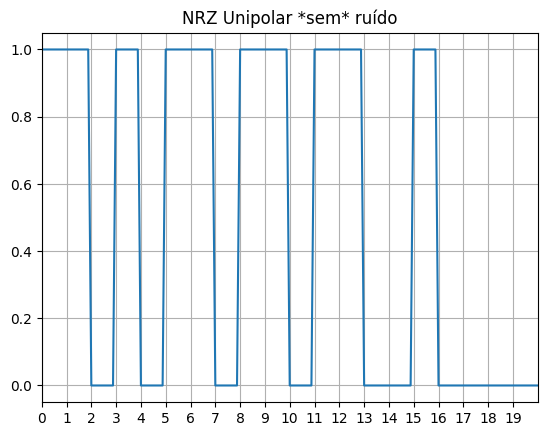

In [152]:
gt, rt, xt = cria_vetores_amostrados(1)
plt.plot(gt)  # Plota os 30 primeiros bits
plt.title('NRZ Unipolar *sem* ruído')
plt.xlim(0, show_amostras)
plt.xticks(range(0, show_amostras, amostras_por_bit),
           range(0, show_amostras//amostras_por_bit))
plt.grid()
plt.show()

## Obtém as amplitudes para cada snr desejada entre -3dB e 10dB, subindo de 1dB em 1dB


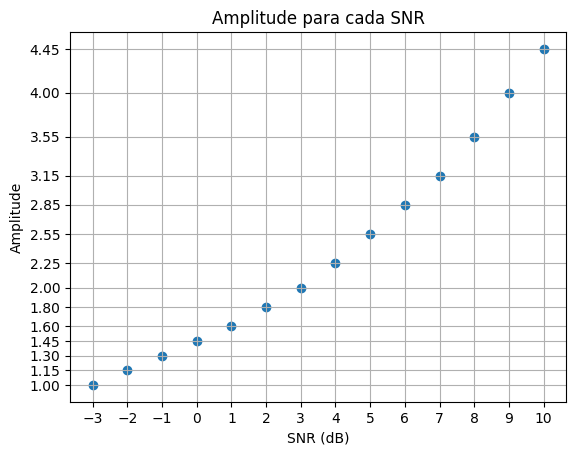

In [153]:
# Aproximadamente 30s
snr_desejadas = range(-3, 11)
amplitudes = [amplitude_para_snr(snr_dB) for snr_dB in snr_desejadas]
plt.scatter(snr_desejadas, amplitudes)
plt.title('Amplitude para cada SNR')
plt.xlabel('SNR (dB)')
plt.ylabel('Amplitude')
plt.xticks(snr_desejadas)
plt.yticks(amplitudes)
plt.grid()
plt.show()

## Exibe a comparação dos sinais transmitidos e recebidos para cada SNR, exibindo o BER


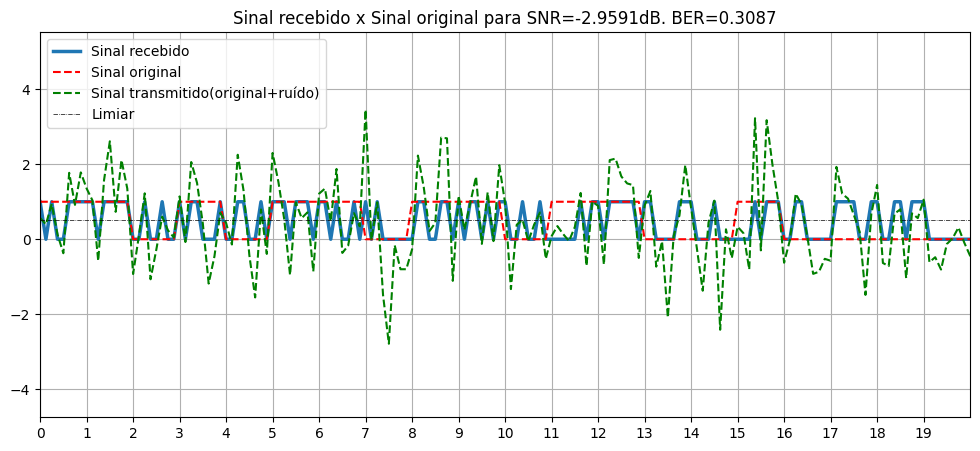

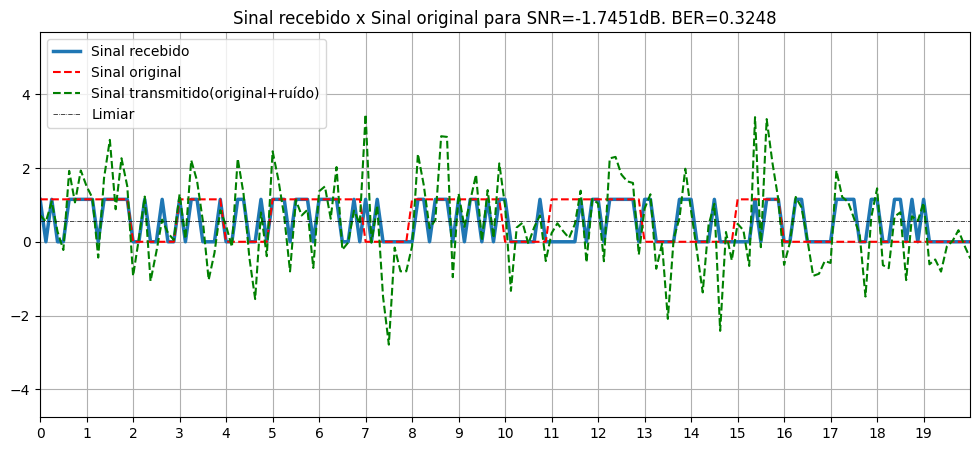

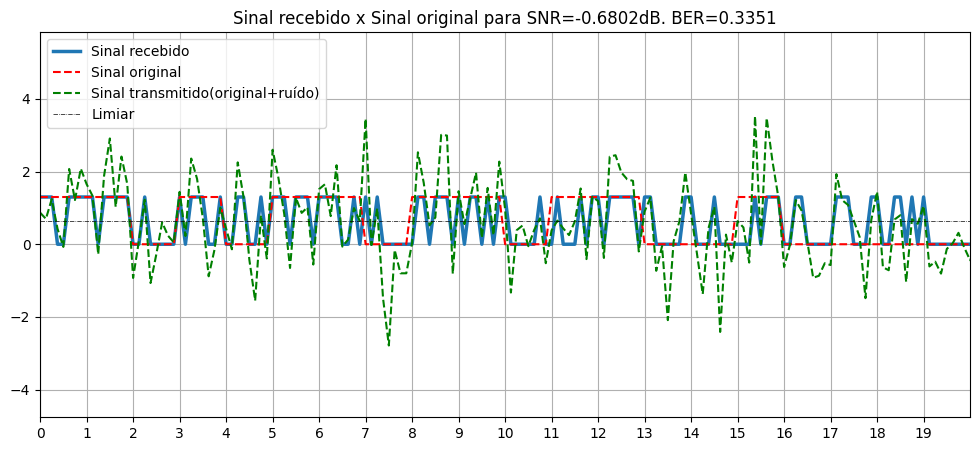

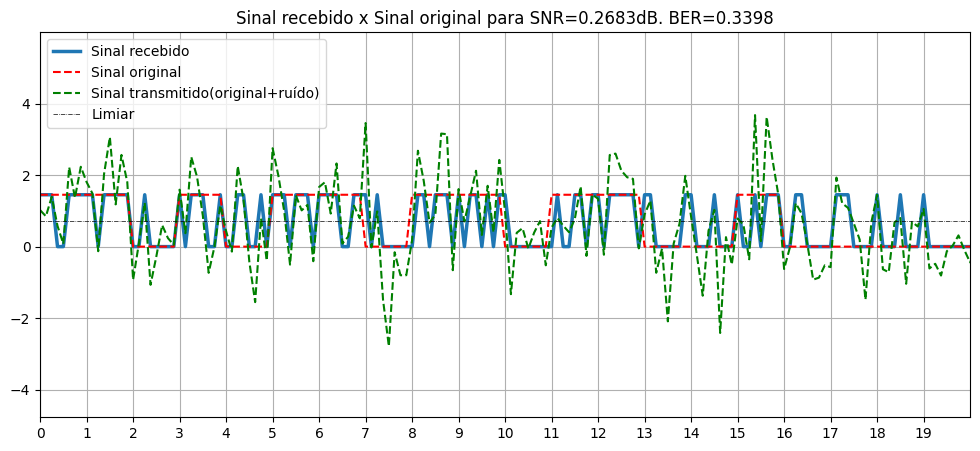

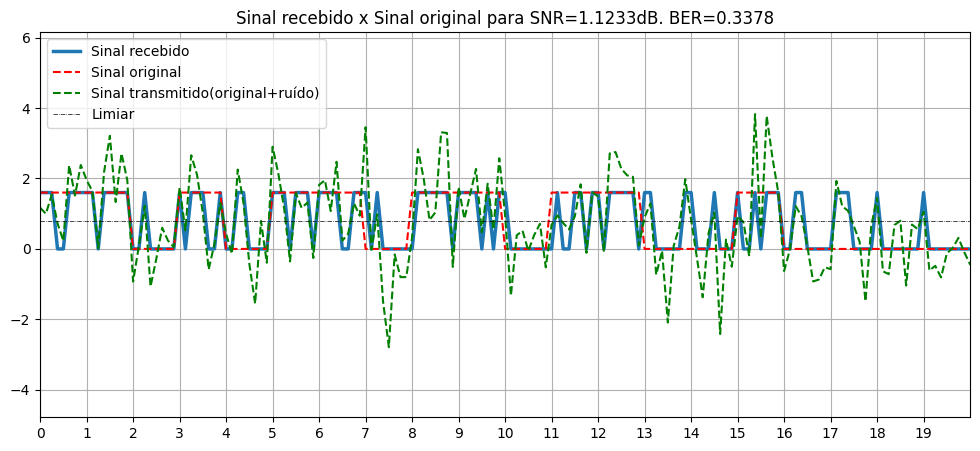

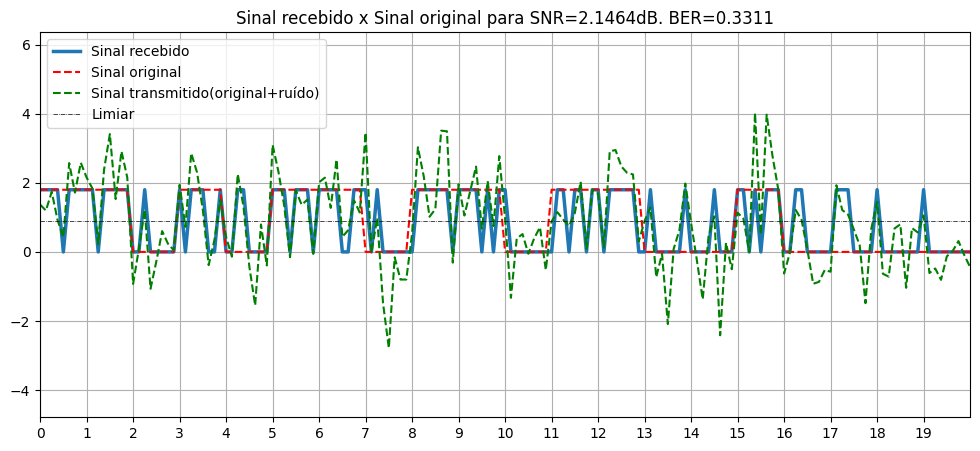

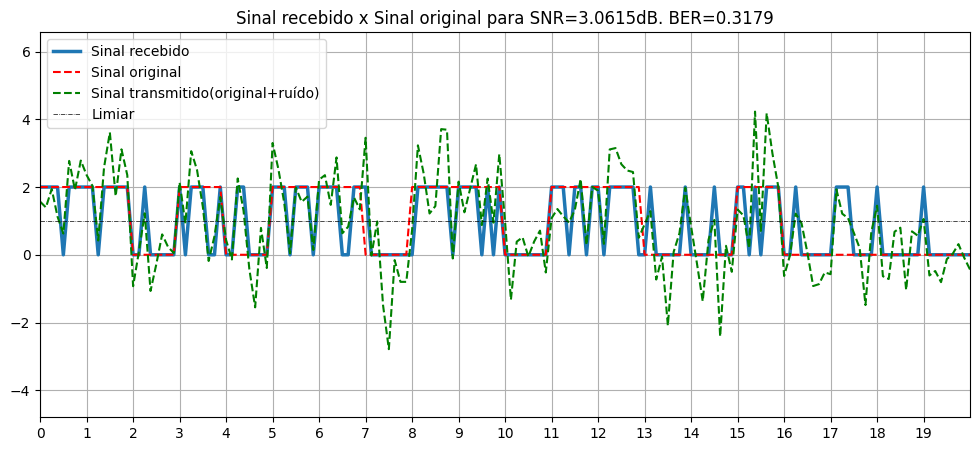

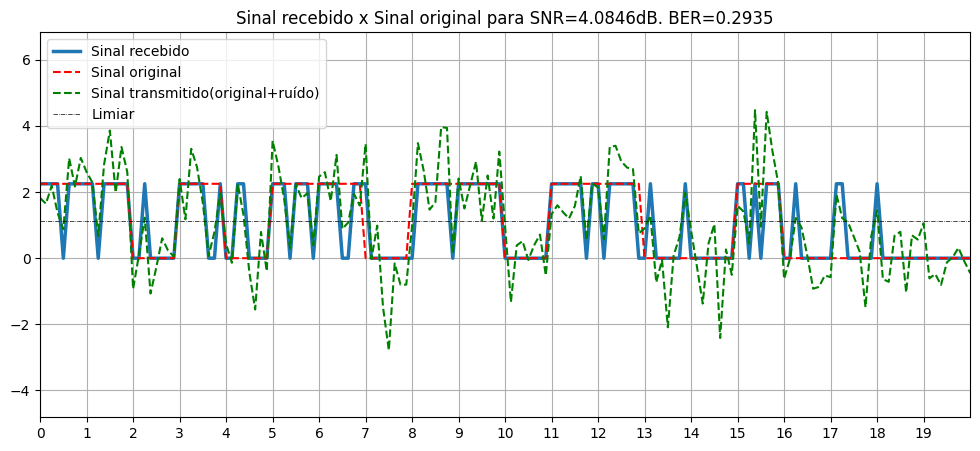

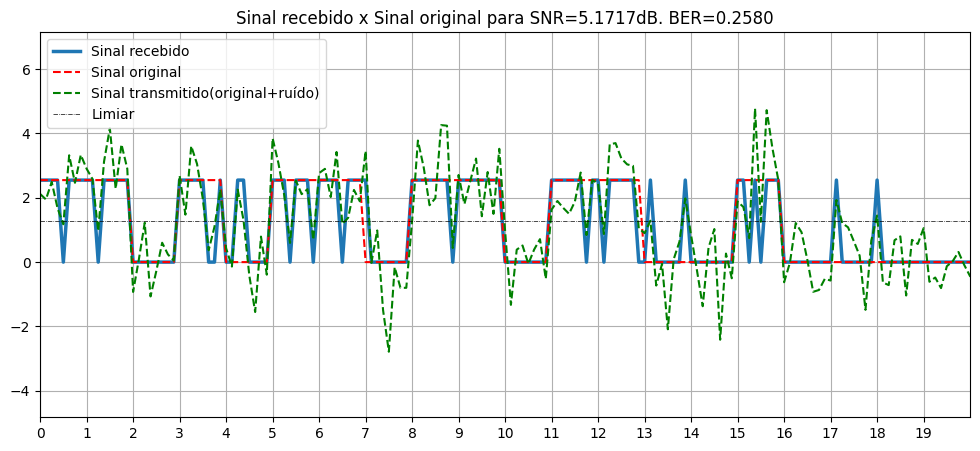

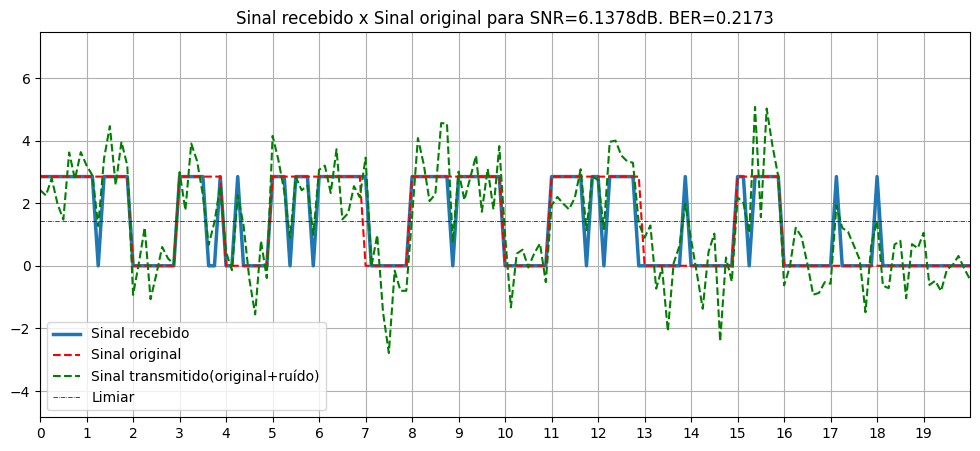

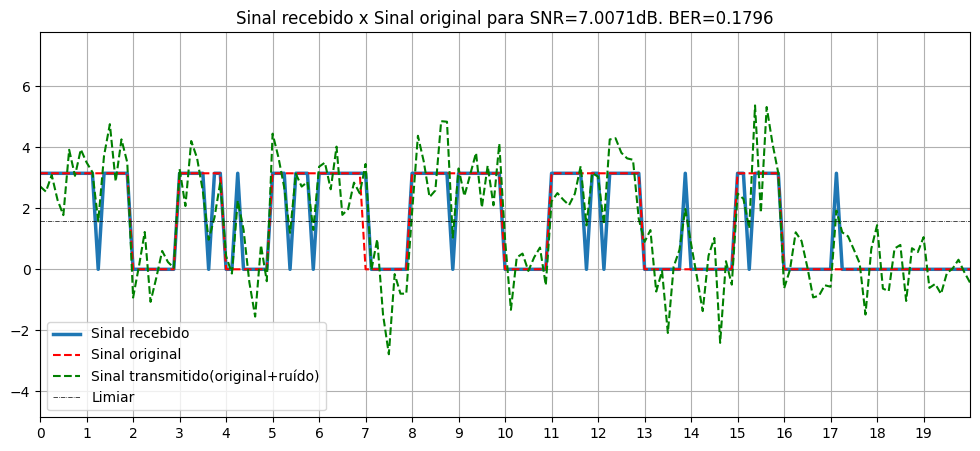

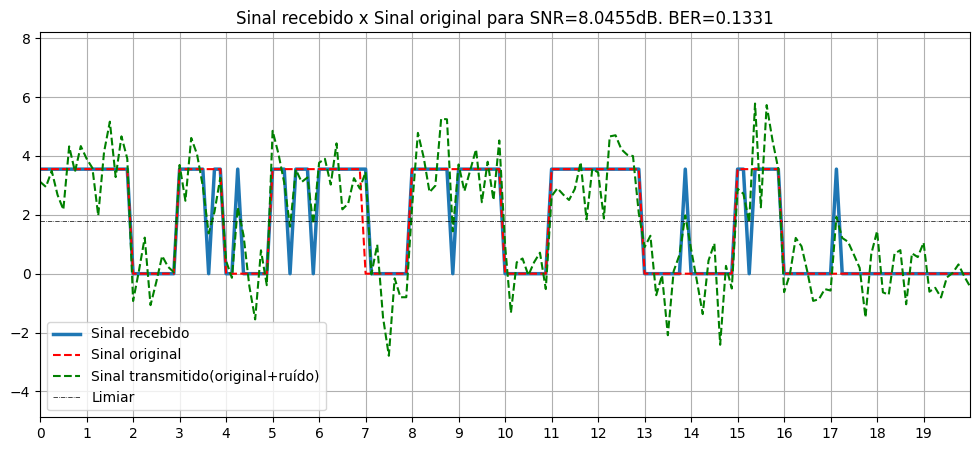

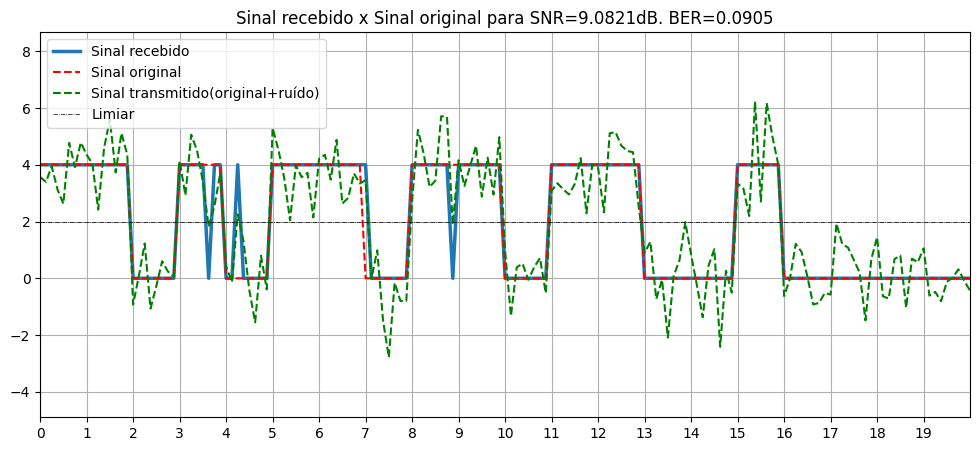

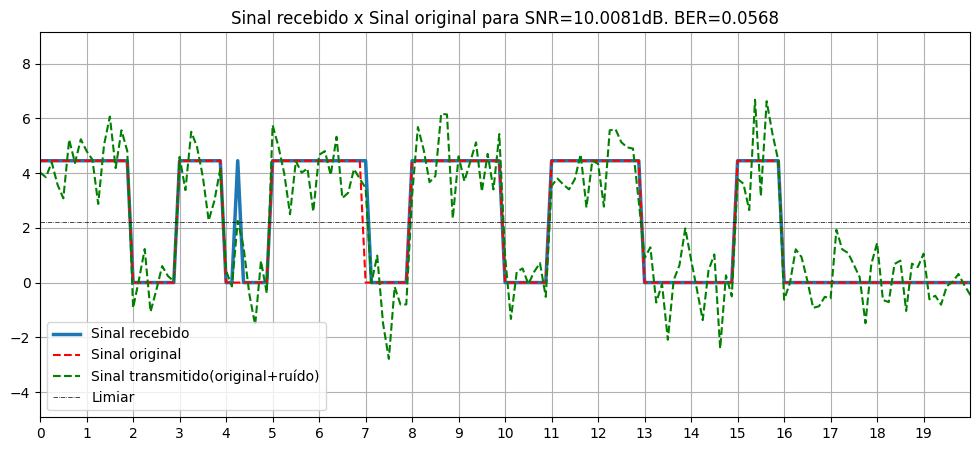

In [154]:
ber_list = []
snr_list = []
for i in range(len(snr_desejadas)):
    ber_value, snr_value = exibe_sinal_recebido(amplitudes, i)

    ber_list.append(ber_value)
    snr_list.append(snr_value)

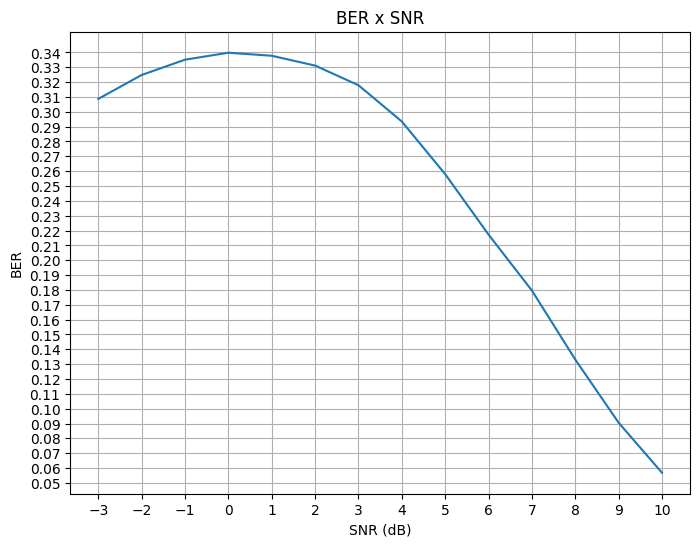

In [155]:
plt.figure(figsize=(8, 6))
plt.title('BER x SNR')
plt.xlabel('SNR (dB)')
plt.ylabel('BER')
plt.xticks(snr_desejadas)
plt.yticks(np.arange(0, .35, 0.01))
plt.grid()
plt.plot(snr_desejadas, ber_list)
plt.show()

# Filtro casado

Para cada bit, será transmitido um sinal elétrico determinado, tal que os dois serão ortogonais¹

- bit 1 = [1,1,1,1,1,1,1,1]
- bit 0 = [1,1,1,1,-1,-1,-1,-1]

¹ : O produto interno dos dois resulta em zero


## Funções alteradas para sinal elétrico


In [156]:
high = [1]*amostras_por_bit
low = [1]*(amostras_por_bit//2) + [-1]*(amostras_por_bit//2)


def cria_vetores_eletricos(amplitude=5):

    np.random.seed(10)  # semente para gerar os mesmos números aleatórios
    # gera um vetor de N bits aleatórios
    gt = np.random.randint(0, 2, n_bits)
    # gt = np.repeat(gt,amostras_por_bit) # repete cada bit pela quantidade de amostras
    gt = np.array([high if bit == 1 else low for bit in gt]).reshape(-1)*amplitude

    # gera um vetor de números aleatórios com distribuição normal
    rt = np.random.normal(0, 1, len(gt))
    xt = gt + rt  # gera o sinal
    return (gt, rt, xt)


In [157]:
def exibe_sinal_recebido(amplitudes_array, index):
    A = amplitudes_array[index]
    gt, rt, xt = cria_vetores_eletricos(amplitude=A)
    # recebido = A se o valor for maior que A/2 e 0 se for menor
    yt = np.where(xt > A/2, A, 0)

    ber = np.sum(np.abs(yt-gt))/len(gt)
    _snr = snr(gt, rt)

    plt.figure(figsize=(12, 5))
    plt.title(
        f'Sinal recebido x Sinal original para SNR={_snr:.4f}dB. BER={ber:.4f}')
    plt.xticks(range(0, show_amostras, amostras_por_bit),
               range(0, show_amostras//amostras_por_bit))
    plt.xlim(0, show_amostras)
    plt.plot(yt, label='Sinal recebido', linewidth=2.5)
    plt.plot(gt, 'r--', label='Sinal original')
    plt.plot(xt, 'g--', label='Sinal transmitido(original+ruído)')

    # Plota o limiar
    plt.plot([0, show_amostras], [A/2, A/2],
             'k-.', label='Limiar', linewidth=.5)

    plt.grid()
    plt.legend()
    plt.show()

    return ber, _snr

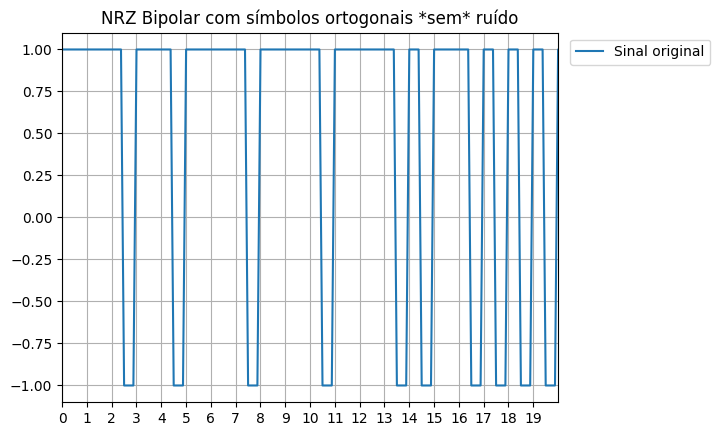

In [158]:
gt, rt, xt = cria_vetores_eletricos(amplitude=1)

plt.plot(gt, label='Sinal original')  # Plota os 30 primeiros bits
plt.title('NRZ Bipolar com símbolos ortogonais *sem* ruído')
plt.xlim(0, show_amostras)
plt.xticks(range(0, show_amostras, amostras_por_bit),
           range(0, show_amostras//amostras_por_bit))
plt.grid()
plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left')
plt.show()

## Convolução entre as entradas ortogonais e seus filtros

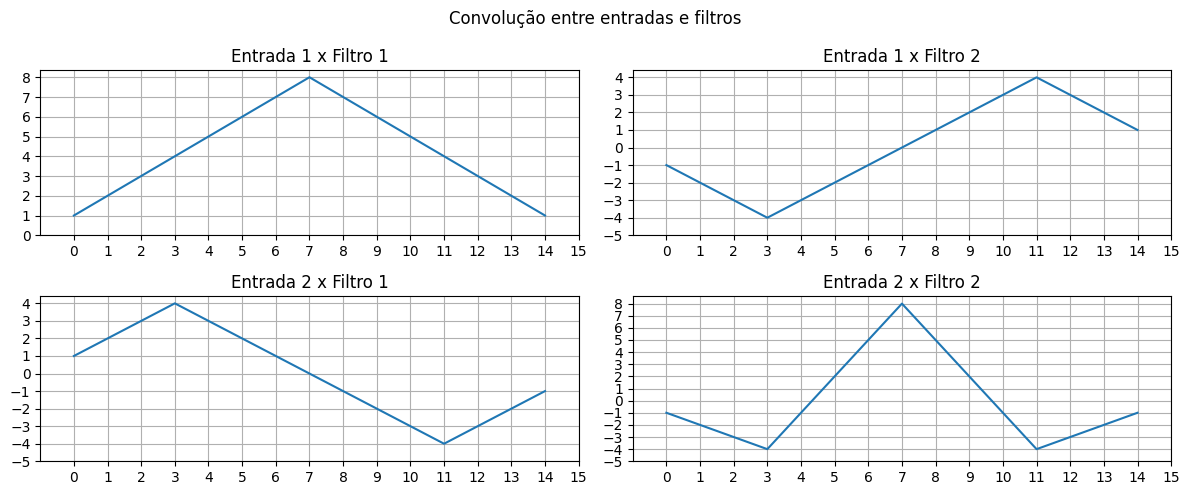

In [159]:
symbols = np.array([high, low])
filters = np.array([high[::-1], low[::-1]])
fig, axes = plt.subplots(figsize=(12, 5), nrows=2, ncols=2)
fig.suptitle('Convolução entre entradas e filtros')

for i in range(len(symbols)):
    for j in range(len(filters)):
        convolve = np.convolve(symbols[i], filters[j], mode='full')
        axes[i, j].plot(convolve)
        axes[i, j].set_title(f'Entrada {i+1} x Filtro {j+1}')
        axes[i, j].set_xlim(-1, len(convolve))
        axes[i, j].set_xticks(np.arange(0, len(convolve)+1))
        axes[i, j].set_yticks(np.arange(min(convolve)-1, max(convolve)+1))
        axes[i, j].grid()

fig.tight_layout()
plt.show()

Observa-se que o o filtro **n** apresenta saída máxima para o símbolo **n** no ponto t=7. E saída 0 para o outro símbolo também no mesmo ponto.


## Exibe a comparação dos sinais transmitidos e recebidos para cada SNR, exibindo o BER


In [160]:
def exibe_sinal_filtro_casado(amplitudes_array, index):
    np.random.seed(10)  # semente para gerar os mesmos números aleatórios
    A = amplitudes_array[index]
    gt, rt, xt = cria_vetores_eletricos(amplitude=A)

    yt = []
    for symbol in range(0, len(xt), amostras_por_bit):
        f1 = np.convolve(xt[symbol:symbol+amostras_por_bit], filters[0])
        f2 = np.convolve(xt[symbol:symbol+amostras_por_bit], filters[1])
        if f1[7] > f2[7]:
            yt.append(high)
        else:
            yt.append(low)

    yt = np.array(yt).reshape(-1)*A

    ber = np.sum(np.abs(yt-gt))/len(gt)
    _snr = snr(gt, rt)

    plt.plot(yt, label='Sinal recebido')  # Plota os 30 primeiros bits
    plt.plot(gt, 'r--', label='Sinal original')
    plt.plot(xt, 'g--', label='Sinal transmitido(original+ruído)')
    plt.title(f'NRZ Bipolar. SNR={_snr:.4f}dB. BER={ber:.8f}')
    plt.xlim(0, show_amostras)
    plt.xticks(range(0, show_amostras, amostras_por_bit),
               range(0, show_amostras//amostras_por_bit))
    plt.grid()
    plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left')
    plt.show()

    return ber, _snr

In [161]:
amplitudes_eletricas = [amplitude_para_snr(snr_dB, cria_vetores_eletricos) for snr_dB in snr_desejadas]

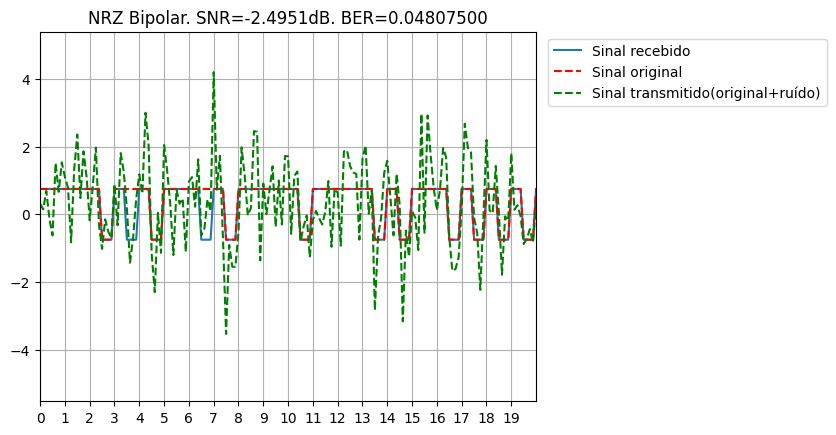

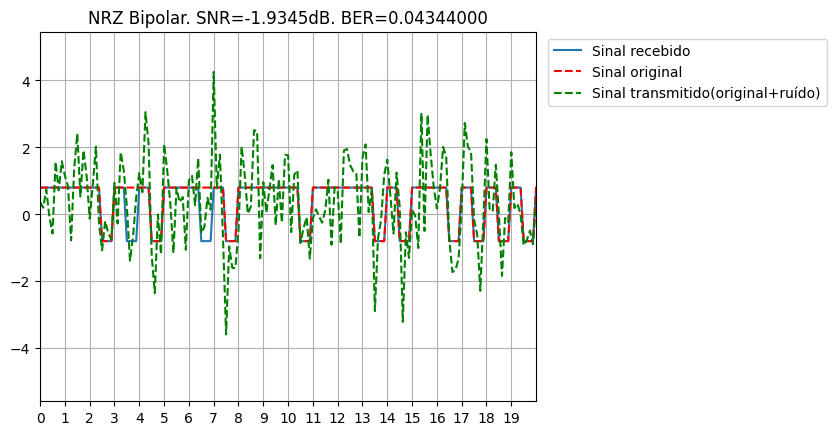

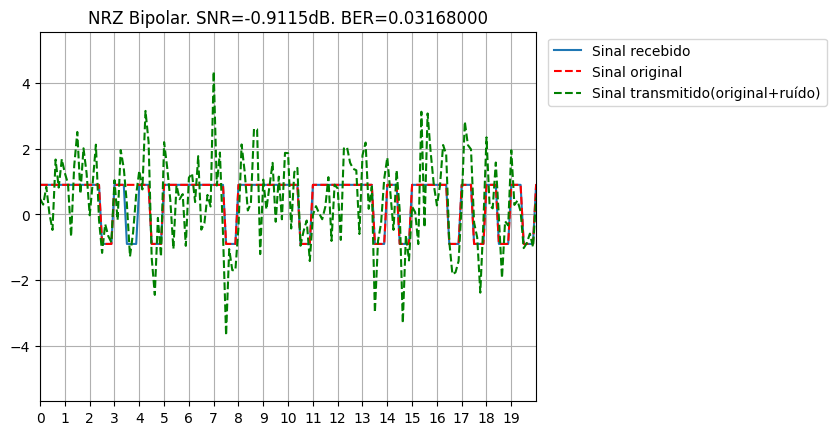

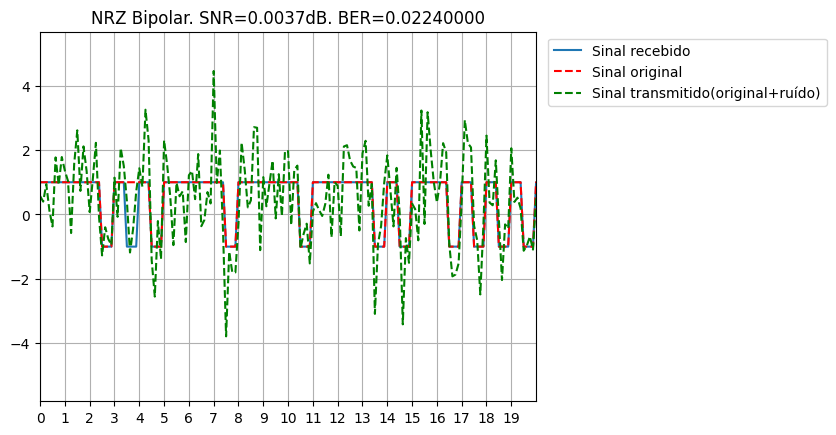

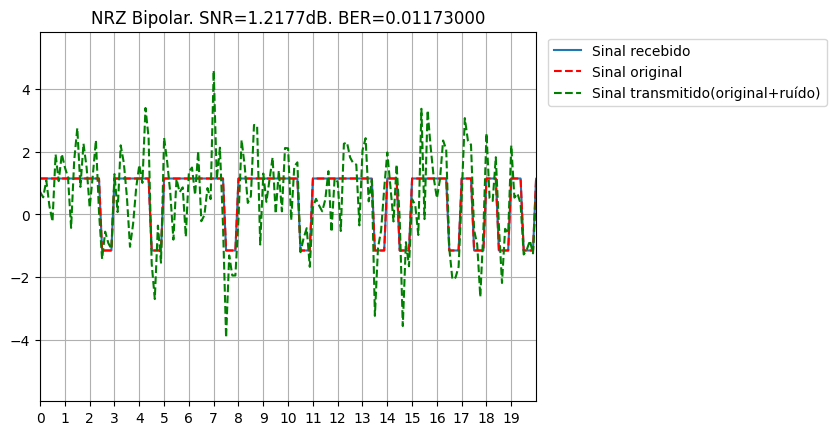

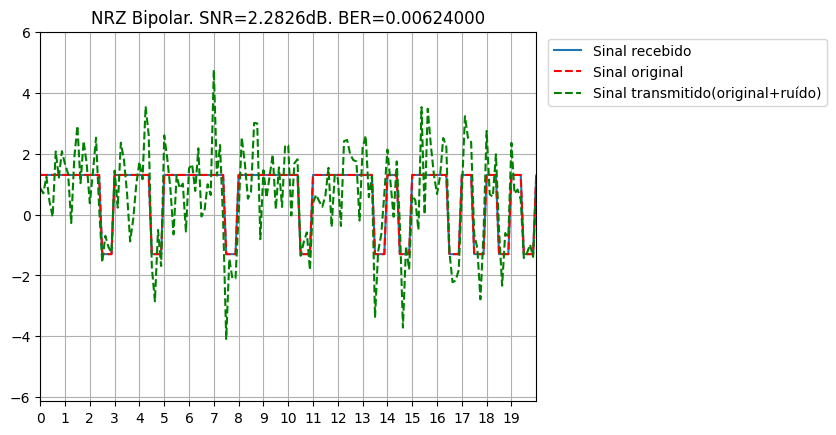

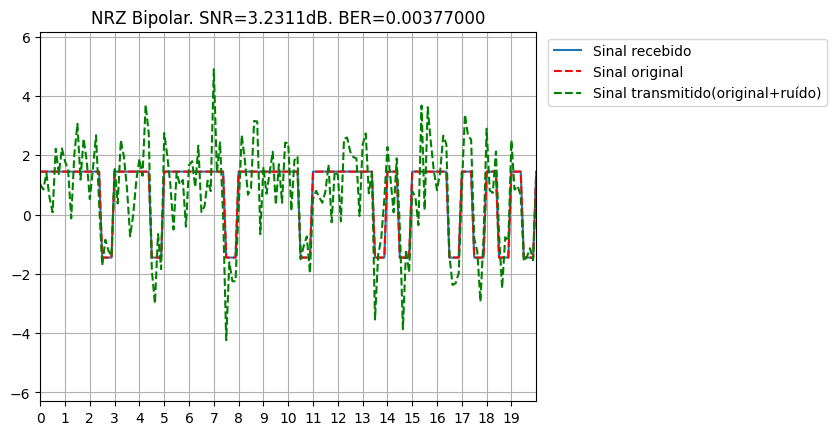

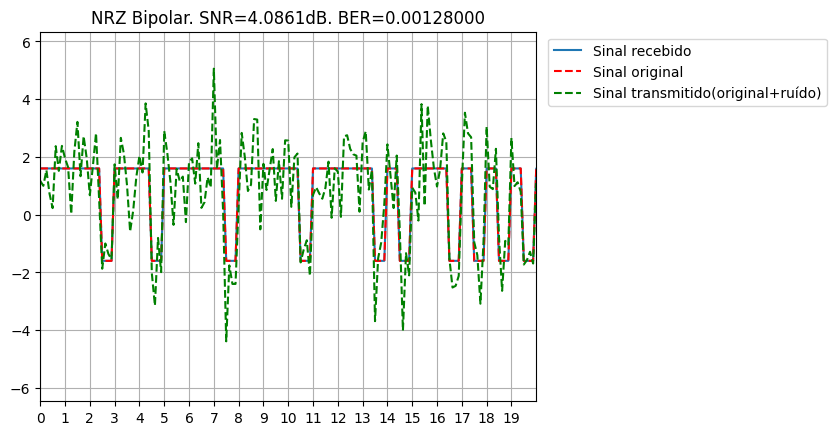

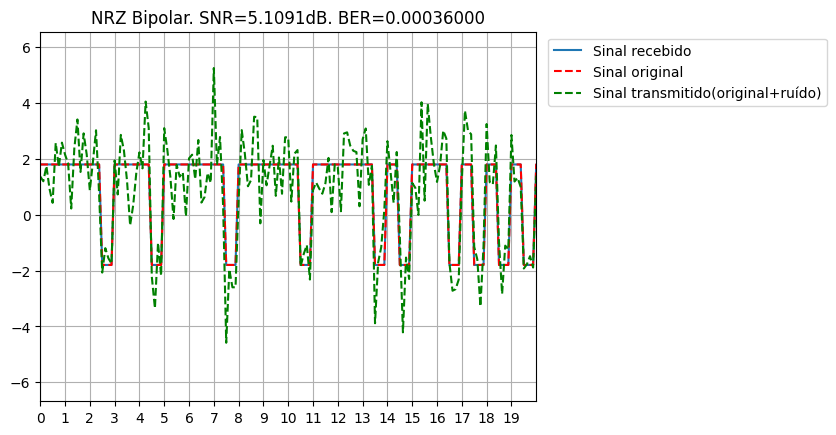

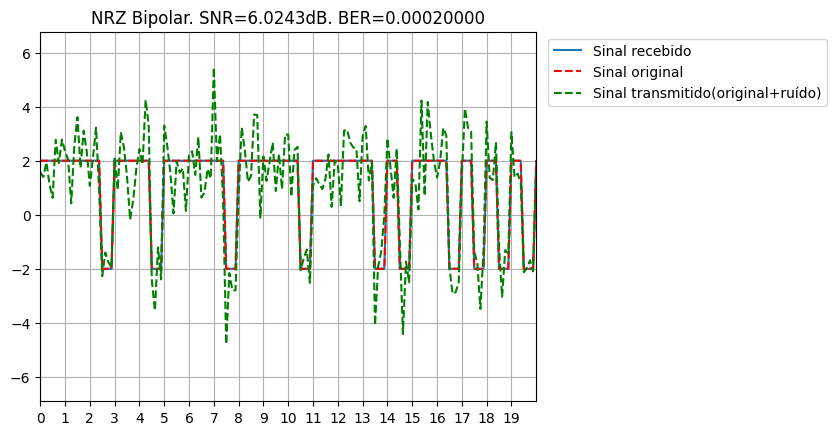

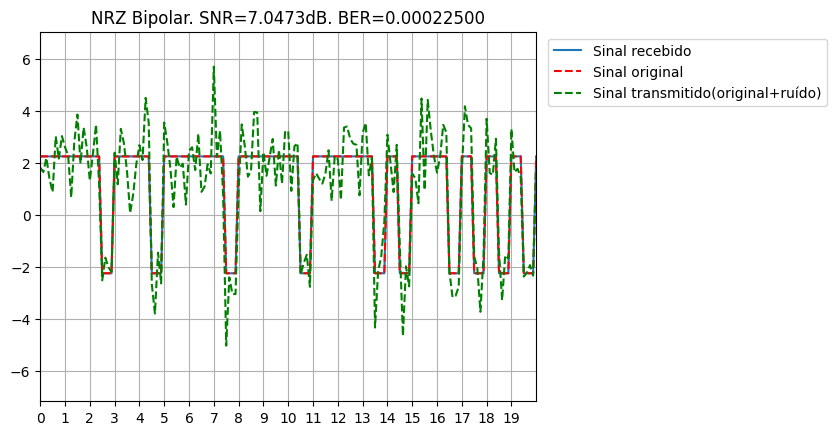

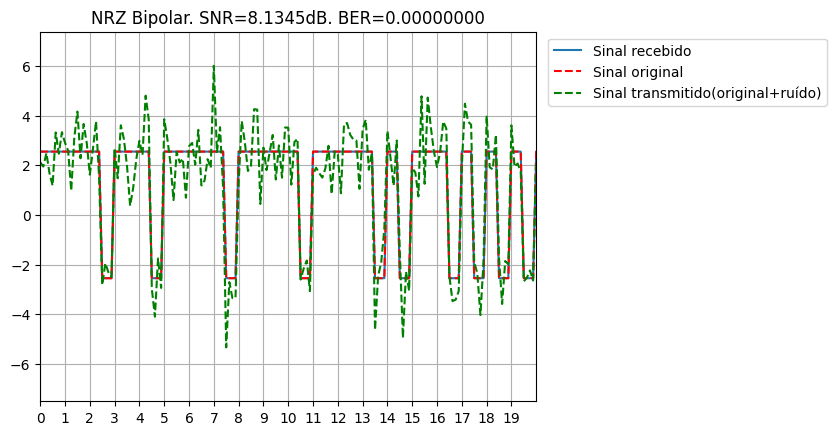

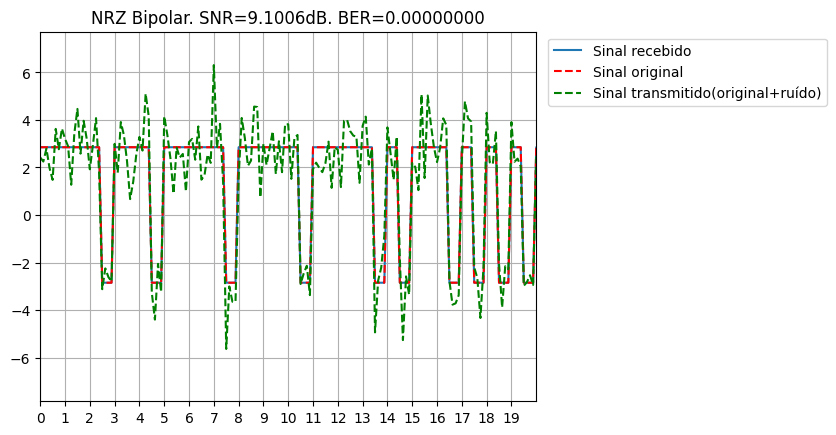

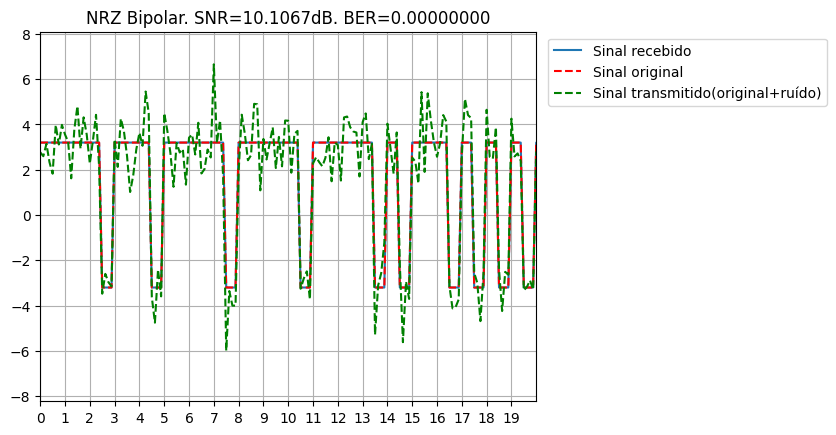

In [162]:
ber_eletricos = []
snr_eletricos = []
for i in range(len(snr_desejadas)):
    ber_value, snr_value = exibe_sinal_filtro_casado(amplitudes_eletricas, i)
    ber_eletricos.append(ber_value)
    snr_eletricos.append(snr_value)

Observa-se que a partir de SNR>8dB não há mais erro de bit

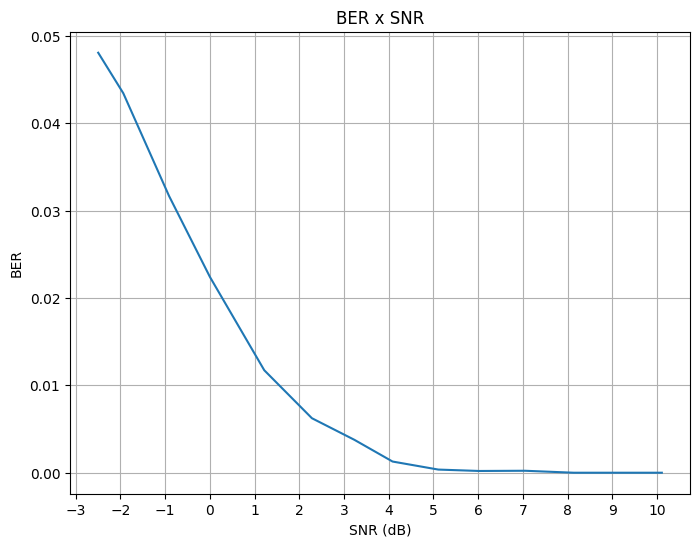

In [163]:
plt.figure(figsize=(8, 6))
plt.title('BER x SNR')
plt.xlabel('SNR (dB)')
plt.ylabel('BER')
plt.xticks(snr_desejadas)
# plt.yticks(np.arange(0,.35,0.01))
plt.grid()
plt.plot(snr_eletricos, ber_eletricos)
plt.show()

# Conclusão


Foi possível desenvolver a avaliar o método de recuperação de bits tradicional e compará-lo ao método de filtro casado.
Observou-se que ao aumentar a amplitude do sinal e, consequentemente o **SNR**, o **BER** também tende a reduzir.
Já com a codificação do sinal em vetores ortogonais e filtros casados, notou-se que a partir de `SNR>8dB`, já não há mais erro de bit para dois símbolos.